# **Electricity Demand Estimation For Leading Electricity Distributor**

### **Business Context** :
One of leading electricity Distribution Company would like to understand demand for electricity for 
the next 1-2 years to manage the production of electricity and managing the vendors for the same. It 
is one of the important exercises to getting accurate estimation of demand so that they can procure 
or produce the electricity as per the demand.

### **Available Data :** 
The data of monthly electricity consumption available starting from January 1973 to December 2019. 
We need to forecast the demand for next two years.
1. Date – Month & Year
2. Electricity Consumption – Electricity consumption in Trillion Watts

### **Business Objective :**
1. Need to forecast the demand of electricity for next 1-2 years.
2. Calculate error metrics (RMSE, RMSPE, MAPE)
3. Compare various models including Decomposition, ETS models, ARIMA/SARIMA Models with 
various parameter.

________________________________________

**Import libraries**

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from statsmodels.tsa.seasonal import  seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import ParameterGrid
import pmdarima as pm
from pmdarima import auto_arima
from pmdarima import model_selection
plt.style.use('ggplot')
import pickle 

import warnings
warnings.filterwarnings('ignore')

**Read the Data**

In [4]:
df = pd.read_csv("data/Electricity Consumption.csv")
df.head()

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625
3,4/1/1973,33.8416
4,5/1/1973,33.5107


In [5]:
# check the data
df.head()

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625
3,4/1/1973,33.8416
4,5/1/1973,33.5107


In [6]:
# rename the feature names 
df.columns = ['date', 'electricity_consumption']

In [7]:
# information about data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     561 non-null    object 
 1   electricity_consumption  561 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.9+ KB


In [8]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,electricity_consumption
0,1973-01-01,35.9728
1,1973-02-01,36.1334
2,1973-03-01,35.0625
3,1973-04-01,33.8416
4,1973-05-01,33.5107


In [9]:
# create month and year feature for analilsys 
df['year'] = df['date'].dt.year
df['month'] =  df['date'].dt.month
df.head()

,date,electricity_consumption,year,month
0,1973-01-01,35.9728,1973,1
1,1973-02-01,36.1334,1973,2
2,1973-03-01,35.0625,1973,3
3,1973-04-01,33.8416,1973,4
4,1973-05-01,33.5107,1973,5


In [10]:
# set date as an index
df.set_index('date', inplace=True)
df.head()

,electricity_consumption,year,month
date,,,
1973-01-01,35.9728,1973,1
1973-02-01,36.1334,1973,2
1973-03-01,35.0625,1973,3
1973-04-01,33.8416,1973,4
1973-05-01,33.5107,1973,5


In [11]:
# set the frequency
df.index.freq = 'MS'

### **EDA**

In [12]:
# descriptive statistics 
df['electricity_consumption'].describe()

count    561.000000
mean      76.681764
std       22.756474
min       33.510700
25%       55.919700
50%       78.417000
75%       93.840600
max      123.216300
Name: electricity_consumption, dtype: float64

**Plotting the time series data**

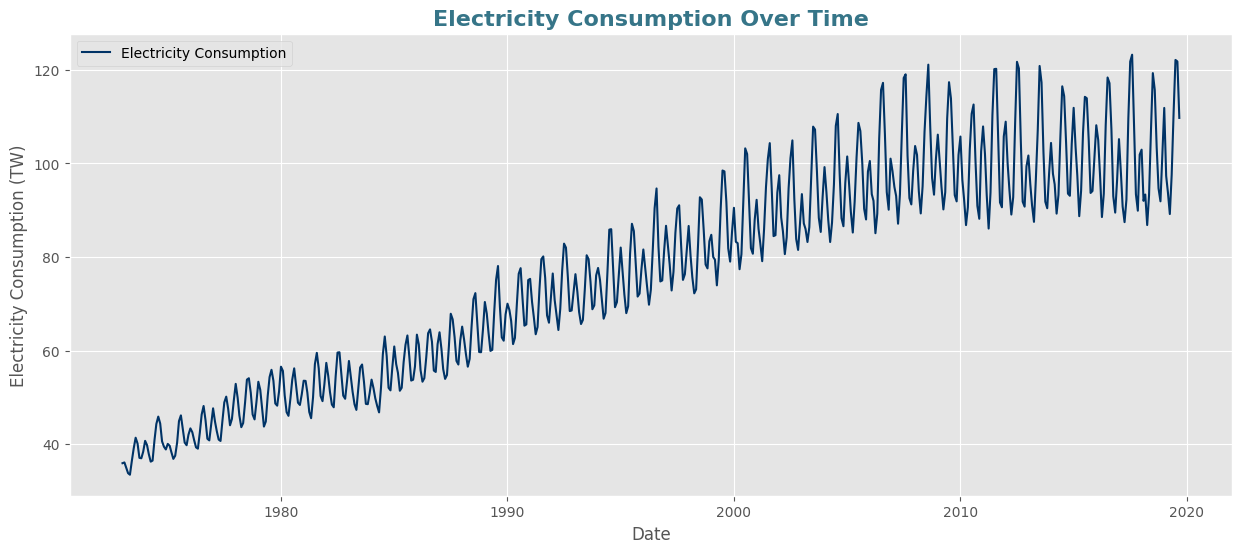

In [13]:
# Plot the time series
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['electricity_consumption'], label='Electricity Consumption', color='#003366')
plt.title('Electricity Consumption Over Time', weight='bold', fontsize=16, color='#367588')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption (TW)')
plt.legend()
plt.show()

**Plot the histogram to check the  time series data distribution and check for outliers**

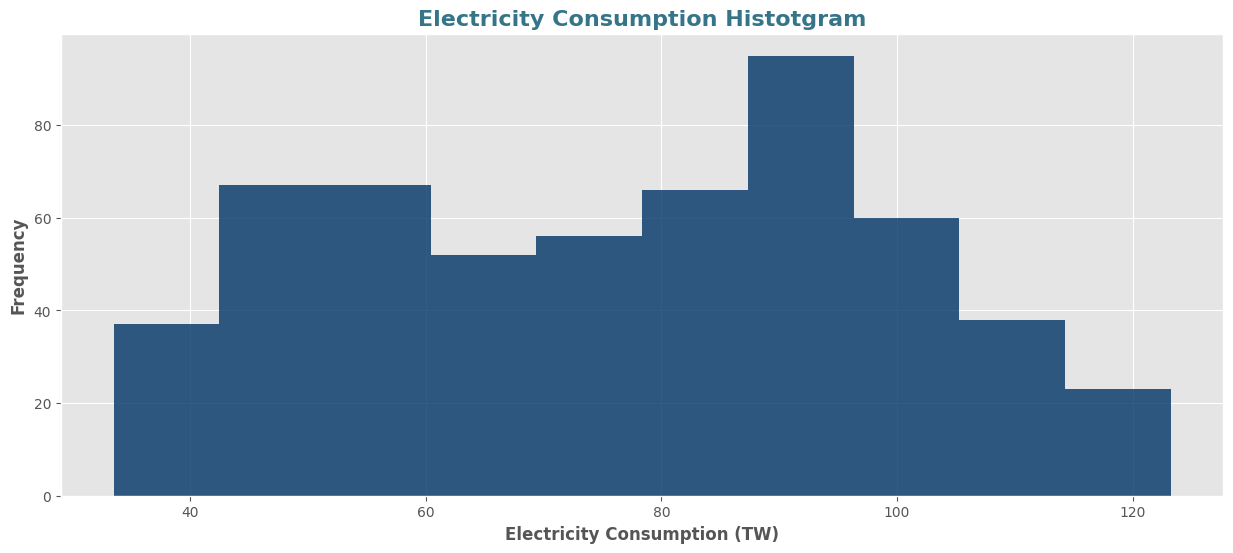

In [14]:
# electricity consumption distribution 
# Plot the time series
plt.figure(figsize=(15, 6))
plt.hist(df['electricity_consumption'], color='#003366', alpha=0.8)
plt.title('Electricity Consumption Histotgram', weight='bold', fontsize=16, color='#367588')
plt.ylabel('Frequency', weight='bold')
plt.xlabel('Electricity Consumption (TW)',  weight='bold')
plt.show()


we can notice there are no outliers in out time series data. 

**Plot and analyse Yearly Trends**

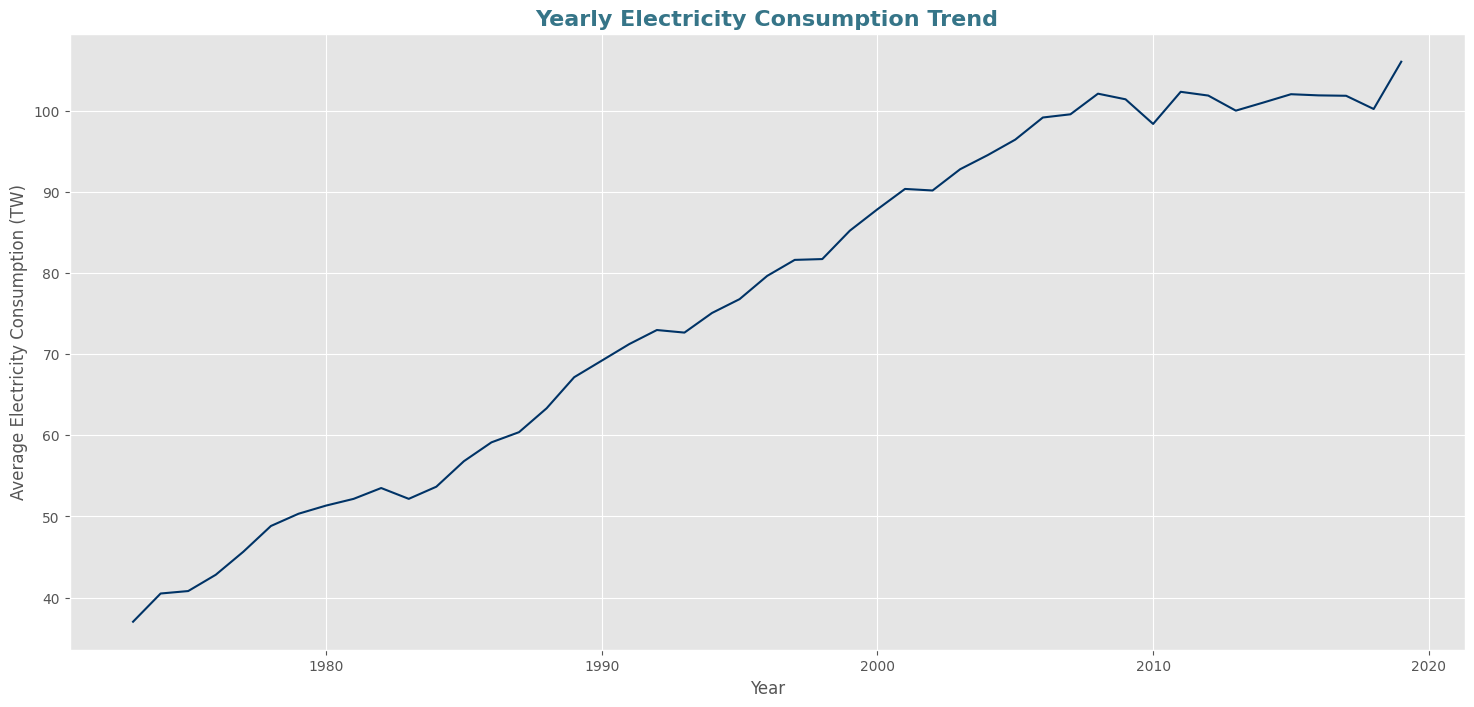

In [15]:
# Explore yearly trends
yearly_mean = df.groupby('year')['electricity_consumption'].mean()
plt.figure(figsize=(18, 8))
sns.lineplot(x=yearly_mean.index, y=yearly_mean.values, color='#003366' )
plt.title('Yearly Electricity Consumption Trend',  weight='bold', fontsize=16, color='#367588' )
plt.xlabel('Year')
plt.ylabel('Average Electricity Consumption (TW)')
plt.show()

We can see the trend of increasing electricity consumption ove the years. 

#### **Seasonal Graphs**

**Monthly Electricity consumption**

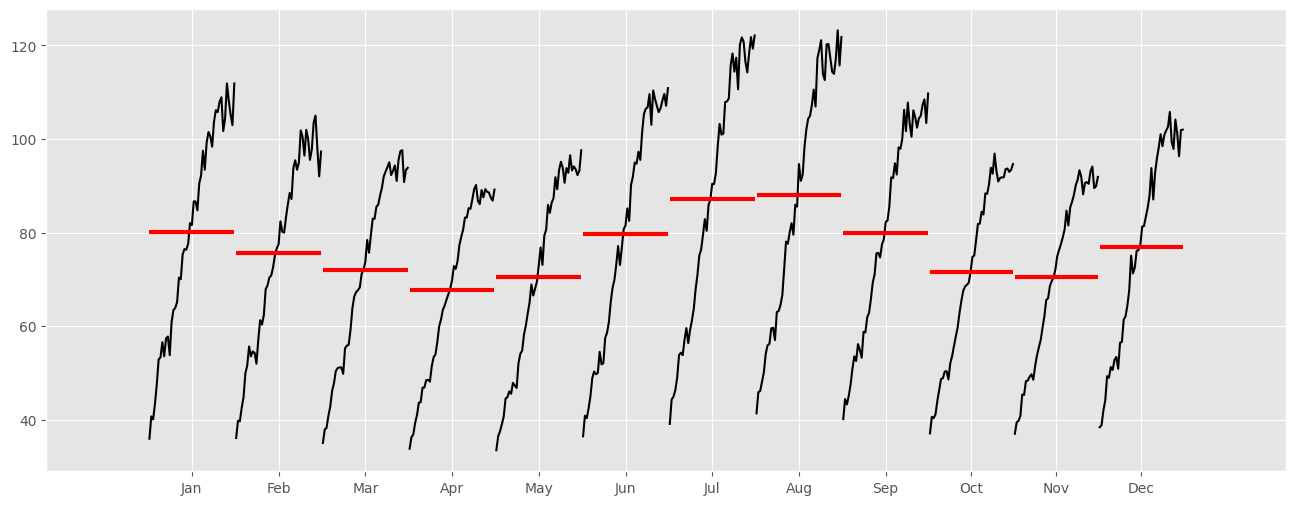

In [16]:
# monthly electricity trends 
plt.rcParams['figure.figsize'] = (16,6)
month_plot(df['electricity_consumption'])
plt.show()

**Quarterly Electricity consumption**

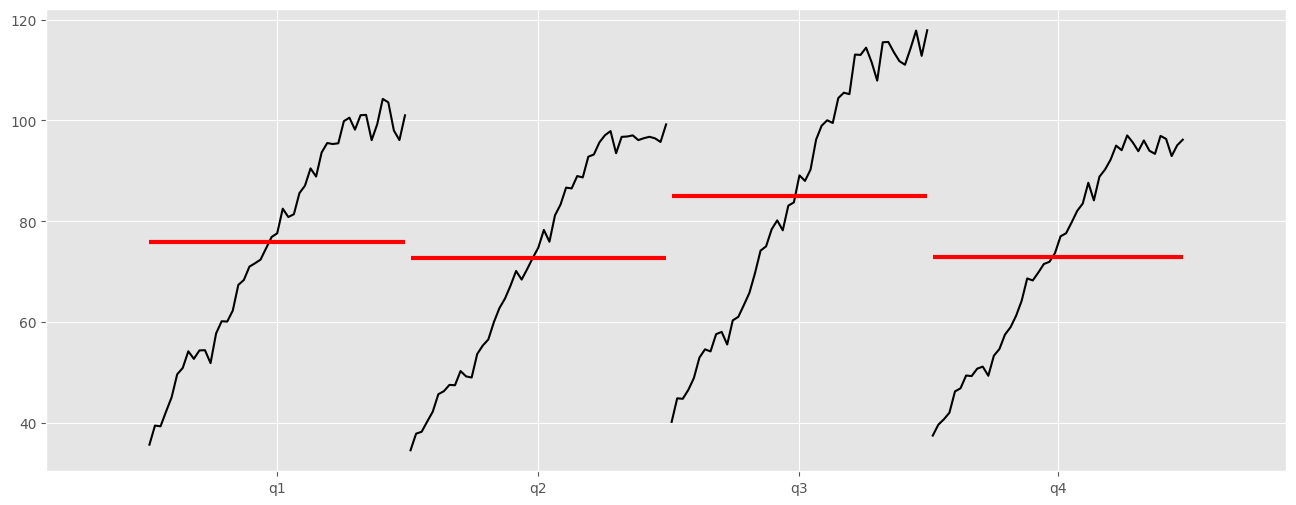

In [17]:
# quarterly electricity trends 
plt.rcParams['figure.figsize'] = (16,6)
quarter_plot(df['electricity_consumption'].resample(rule='Q').mean())
plt.show()

#### **Seasonal Decomposition**

Decompose the time series data into its components (trend, seasonality and residual). We use `seasonal_decompose` function from the statsmodels library. 

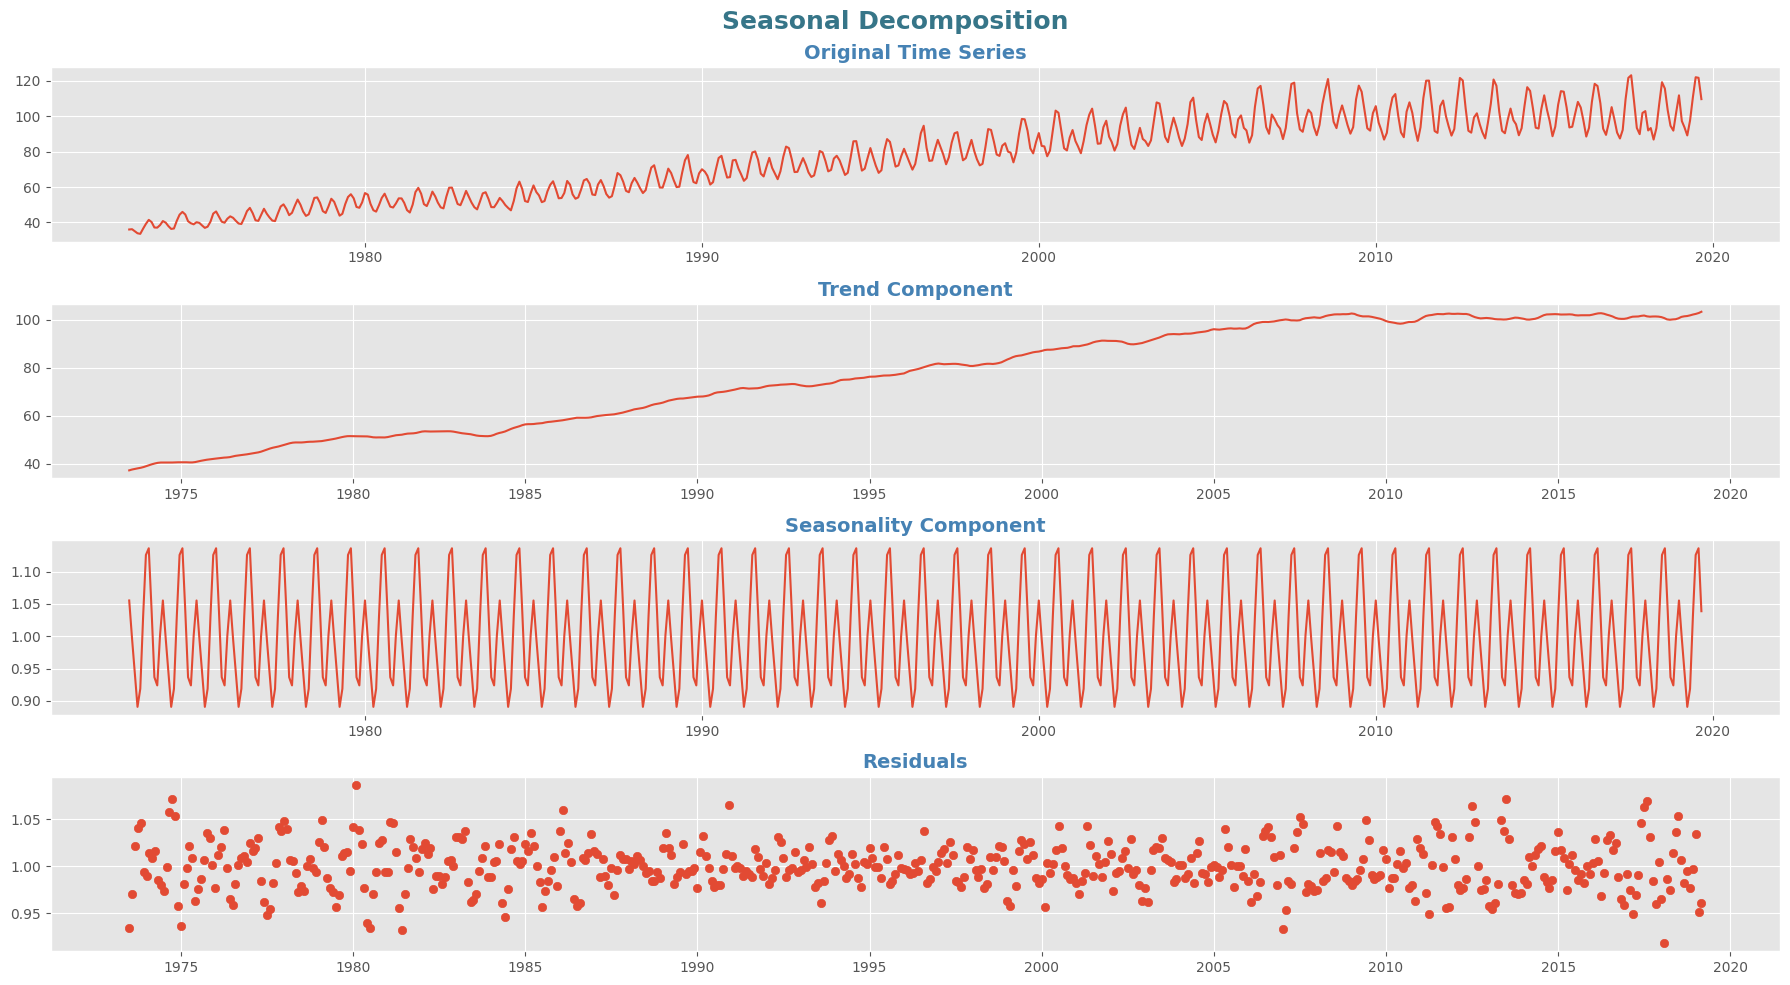

In [18]:
# decompose the the time series 
decomposition = seasonal_decompose(df['electricity_consumption'], model='multiplicative', period=12)

# Plot the original time series, trend, seasonality, and residuals
plt.figure(figsize=(18, 10))
plt.suptitle('Seasonal Decomposition', weight='bold', fontsize=18, color='#367588')
plt.subplot(4, 1, 1)
plt.plot(df.index, df['electricity_consumption'], label='Original Time Series')
plt.title('Original Time Series', weight='bold', fontsize=14, color='#4682b4')

plt.subplot(4, 1, 2)
plt.plot(df.index, decomposition.trend, label='Trend')
plt.title('Trend Component', weight='bold', fontsize=14, color='#4682b4')

plt.subplot(4, 1, 3)
plt.plot(df.index, decomposition.seasonal, label='Seasonality')
plt.title('Seasonality Component', weight='bold', fontsize=14, color='#4682b4')

plt.subplot(4, 1, 4)
plt.scatter(df.index, decomposition.resid, label='Residuals')
plt.title('Residuals', weight='bold', fontsize=14, color='#4682b4')

plt.tight_layout()
plt.show()

In [19]:
# drop month and year features 
df_ts  = df.drop(['year', 'month'], axis=1)

In [20]:
# set the frequency of the time-series index to 'MS' (month start)
df_ts.index.freq = 'MS'

#### **Train-Test Split :**

In [21]:
# last 24 months as test set for validation
Ntest = 24
train_size = len(df_ts) - Ntest
train_data, test_data = df_ts.iloc[:train_size], df_ts.iloc[train_size:]
train_data.shape, test_data.shape

((537, 1), (24, 1))

#### **Function to Calculate Error Metrics :**

In [22]:
def error_metrics(test, pred):
   rmse = np.sqrt(mean_squared_error(test, pred))
   rmspe = np.sqrt(np.mean(((test - pred) / test)**2)) * 100
   mape = np.mean(np.abs((test-pred)/ test)) * 100
   return {'RMSE': rmse, 'RMSPE': rmspe, 'MAPE':mape}

### **ETS Model:**

The ETS (Error, Trend, Seasonality) model is a widely used method for time series forecasting that decomposes a time series into three main components: error, trend, and seasonality. This model is particularly useful for capturing and analyzing the patterns present in time-series data.

In [23]:
# Instantiate ETS model with multiplicative trend and seasonality
ets_model = ExponentialSmoothing(train_data,
                                 trend='multiplicative', seasonal='multiplicative', seasonal_periods=12, 
                                 initialization_method='legacy-heuristic'
                                 )
# fit the ETS model to the training data                               
ets_fit = ets_model.fit()
# Generate forecast for the test set
ets_predictions = ets_fit.forecast(steps=len(test_data))

In [24]:
# test values for evaluation 
test_values = test_data.values

In [25]:
ets_predictions.values

array([ 96.14864815,  94.71801981, 103.85452932, 111.96824307,
       104.83683297,  97.86856671,  91.76973514,  97.09692461,
       112.76182012, 123.58360647, 122.99692201, 110.57344986,
        97.27489632,  95.82751016, 105.07104122, 113.27979588,
       106.06485119,  99.01496135,  92.84469042,  98.23428053,
       114.08266858, 125.03121716, 124.43766051, 111.8686646 ])

In [26]:
test_data.values.ravel()

array([ 93.4264,  89.9026, 101.8836, 102.9398,  92.0095,  93.3526,
        86.8386,  93.2361, 107.1009, 119.2874, 115.7108, 103.407 ,
        94.6492,  91.9079, 101.9883, 111.852 ,  97.3261,  93.8406,
        89.1873,  97.586 , 110.858 , 122.1014, 121.7765, 109.719 ])

In [27]:
ets_pred = ets_predictions.values 

In [28]:
# calculate error metrics 
print("Error Metrics: ")
ets_error = error_metrics(test_values, ets_pred)
print(ets_error)

Error Metrics: 
{'RMSE': 5.30928019773058, 'RMSPE': 15.764575413910572, 'MAPE': 12.525645878551595}


**Examine original time series data with fitted values**

In [29]:
# make a copy of original data to add holtwinters prediction amd visualistion 
df1_hw = df_ts.copy()

In [30]:
# Assign fitted values from the ETS (Holt-Winters) model to the training data indices
df1_hw.loc[train_data.index, 'HoltWinters'] = ets_fit.fittedvalues
# Assign predicted values from the ETS (Holt-Winters) model to the test data indices
df1_hw.loc[test_data.index, 'HoltWinters'] = ets_pred

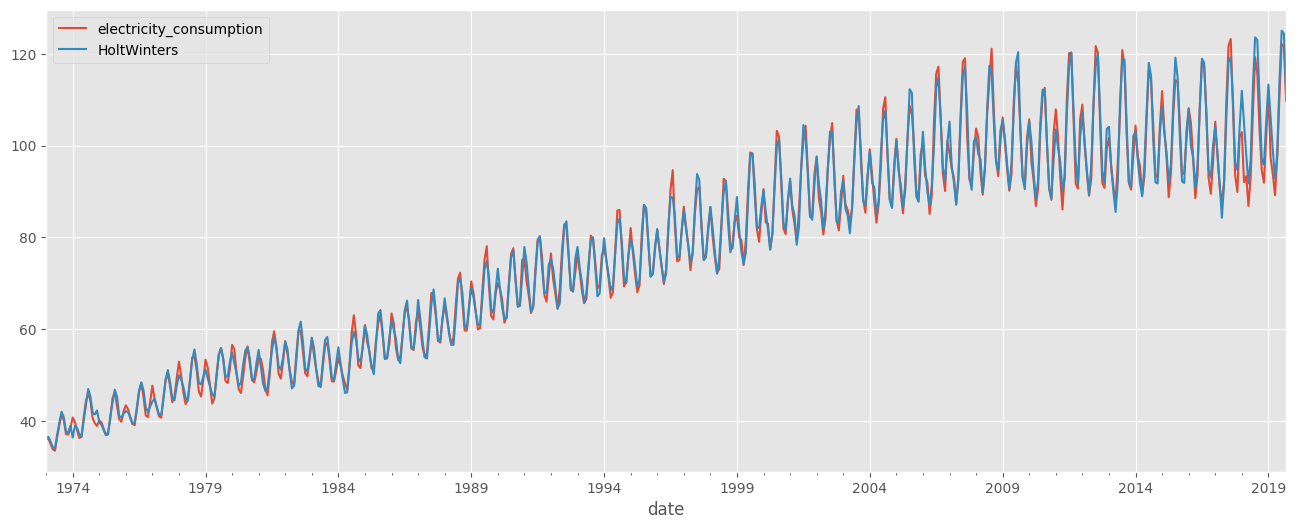

In [31]:
# plot the data 
df1_hw.plot();

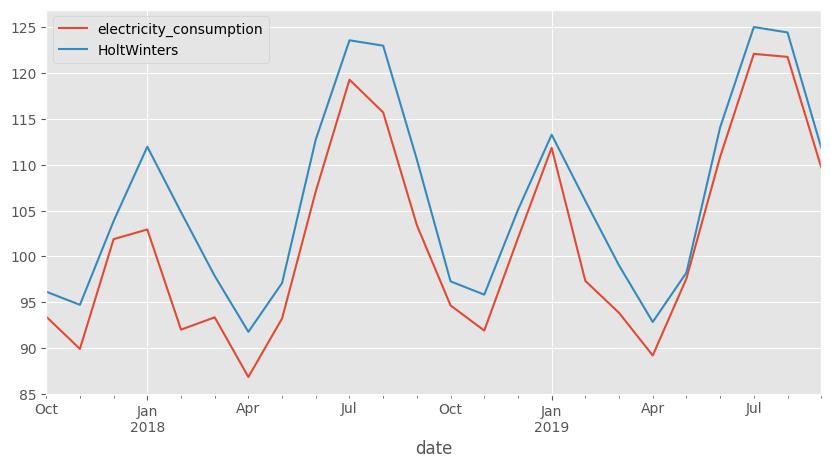

In [32]:
# visualise actual and predicted 
fig, ax = plt.subplots(figsize=(10,5))
df1_hw[train_size:].plot(ax=ax);

#### **Forcasting Electricity demands for next 24 months**

In [33]:
#  define forecast period
forecast_periods = 24

# Instantiate ETS model with multiplicative trend and seasonality
ets_model = ExponentialSmoothing(df_ts,
                                 trend='multiplicative', seasonal='multiplicative', seasonal_periods=12, 
                                 initialization_method='legacy-heuristic'
                                 )
# fit the ETS model to the training data                                 
ets_fit = ets_model.fit()
# Generate forecast for  forcast period 
ets_forecast = ets_fit.forecast(steps=forecast_periods) 

In [34]:
# create a dataframe to store and display the forecast 
df_forcast = pd.DataFrame(ets_forecast, columns=['electricity_demand_forecast'])
print(df_forcast)

            electricity_demand_forecast
2019-10-01                    96.963230
2019-11-01                    94.417786
2019-12-01                   104.904504
2020-01-01                   111.918697
2020-02-01                   101.598161
2020-03-01                    98.786154
2020-04-01                    92.788472
2020-05-01                    99.264991
2020-06-01                   113.413671
2020-07-01                   124.849391
2020-08-01                   123.424443
2020-09-01                   110.235291
2020-10-01                    98.016927
2020-11-01                    95.443822
2020-12-01                   106.044499
2021-01-01                   113.134915
2021-02-01                   102.702226
2021-03-01                    99.859661
2021-04-01                    93.796802
2021-05-01                   100.343702
2021-06-01                   114.646135
2021-07-01                   126.206127
2021-08-01                   124.765694
2021-09-01                   111.433215


In [35]:
#combined dataframe 
df_forcast.columns = ['electricity_consumption']
df_combined = pd.concat([df_ts, df_forcast])

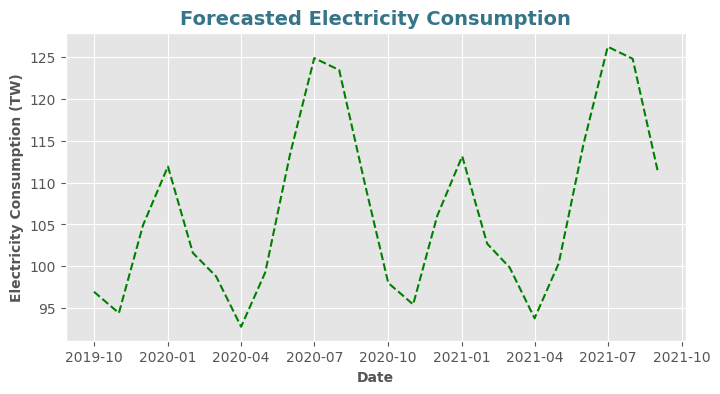

In [36]:
# visualise forecast data 
fig, ax = plt.subplots(figsize=(8,4))
plt.plot(df_forcast.index, df_forcast, label='Forecast', linestyle='dashed', color='green')
plt.title('Forecasted Electricity Consumption', weight='bold', fontsize=14, color='#367588' )
plt.xlabel('Date', weight='bold', fontsize=10)
plt.ylabel('Electricity Consumption (TW)', weight='bold', fontsize=10)
plt.show()

#### **Plot the original and forecasted electricity consumption**

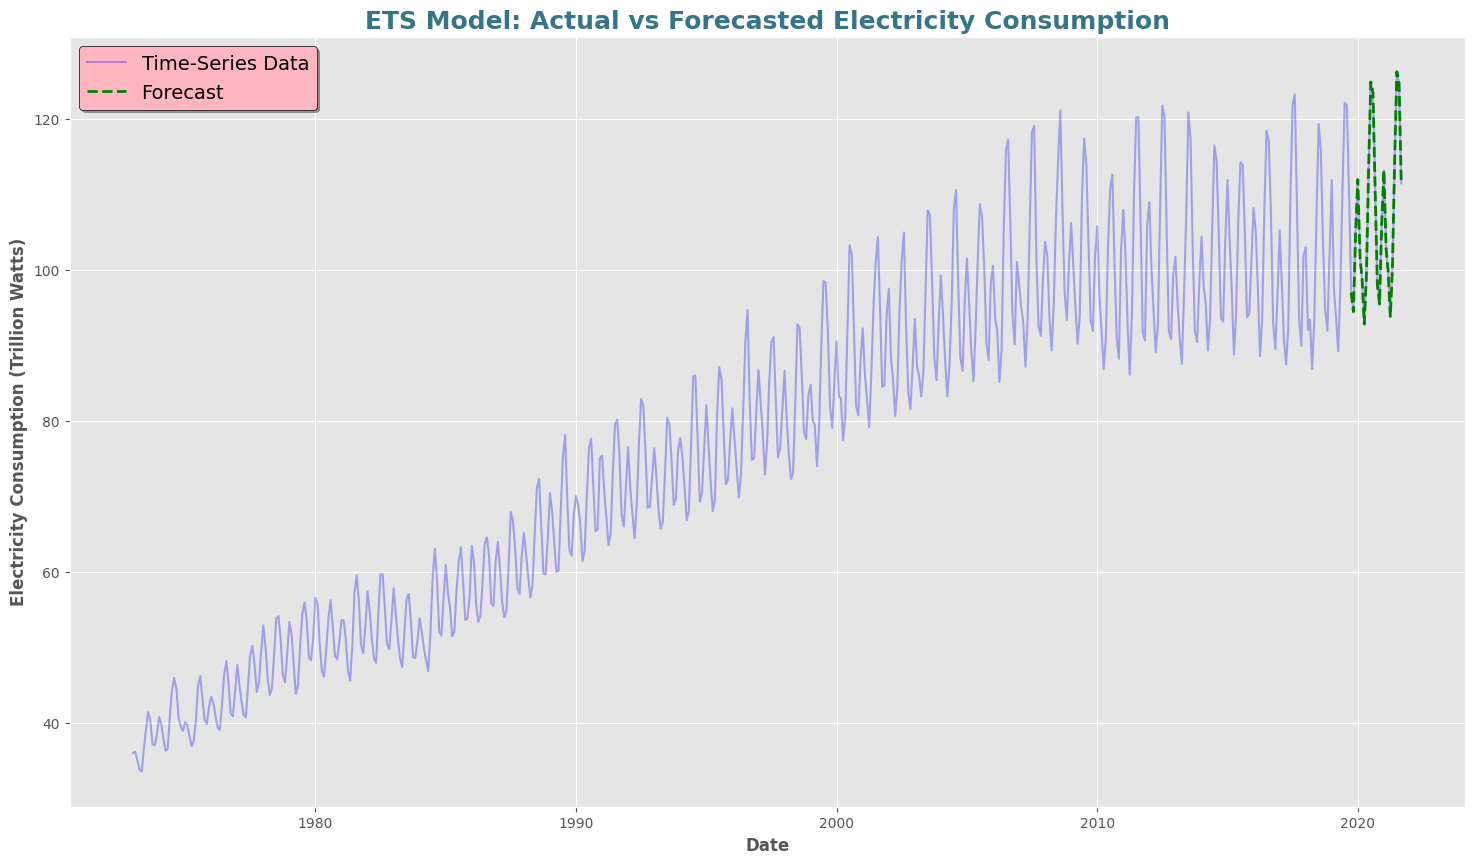

In [37]:
# Plot the actual vs. predicted values
plt.figure(figsize=(18, 10))
plt.plot(df_combined.index, df_combined, label='Time-Series Data', color='blue', alpha=0.3)
plt.plot(df_forcast.index, df_forcast, label='Forecast', linestyle='dashed', color='green', linewidth=2)
plt.title('ETS Model: Actual vs Forecasted Electricity Consumption', weight='bold', fontsize=18, color='#367588')
plt.xlabel('Date', weight='bold')
plt.ylabel('Electricity Consumption (Trillion Watts)', weight='bold')
plt.legend(loc='best', fontsize=14, shadow=True, facecolor='lightpink', edgecolor='k')
plt.show()

_________________________

### **ARIMA and SARIMA Model for Time Series Forecasting**

#### **Autoregressive(AR) Integrated(I) Moving Averages(MA)**

In [38]:
df_ts.head()

,electricity_consumption
date,
1973-01-01,35.9728
1973-02-01,36.1334
1973-03-01,35.0625
1973-04-01,33.8416
1973-05-01,33.5107


In [39]:
# 1st order seasonal differencing 
df_ts['differencing_1'] = df_ts['electricity_consumption'].diff()
# fill missing values 
df_ts.head()

,electricity_consumption,differencing_1
date,,
1973-01-01,35.9728,NaN
1973-02-01,36.1334,0.1606
1973-03-01,35.0625,-1.0709
1973-04-01,33.8416,-1.2209
1973-05-01,33.5107,-0.3309


In [40]:
# seasonal differncing 
df_ts['seasonal_differencing_1'] = df_ts['electricity_consumption'].diff(12)
df_ts.head(20)

,electricity_consumption,differencing_1,seasonal_differencing_1
date,,,
1973-01-01,35.9728,NaN,NaN
1973-02-01,36.1334,0.1606,NaN
1973-03-01,35.0625,-1.0709,NaN
1973-04-01,33.8416,-1.2209,NaN
1973-05-01,33.5107,-0.3309,NaN
1973-06-01,36.4823,2.9716,NaN
1973-07-01,39.1412,2.6589,NaN
1973-08-01,41.4137,2.2725,NaN
1973-09-01,40.1639,-1.2498,NaN


In [41]:
# log value 
df_ts['log_electricity_consumption'] = np.log(df_ts['electricity_consumption'])
df_ts.head()

,electricity_consumption,differencing_1,seasonal_differencing_1,log_electricity_consumption
date,,,,
1973-01-01,35.9728,NaN,NaN,3.582763
1973-02-01,36.1334,0.1606,NaN,3.587218
1973-03-01,35.0625,-1.0709,NaN,3.557132
1973-04-01,33.8416,-1.2209,NaN,3.521691
1973-05-01,33.5107,-0.3309,NaN,3.511865


#### **Check stationarity** 

In [42]:
# write a function to visualise and statistially test stationarity of data. 
def test_stationarity(timeseries):
    # determining rolling statistics 
    rol_mean = timeseries.rolling(12).mean()
    rol_std = timeseries.rolling(12).std()

    # plot rolling statistics 
    plt.figure(figsize=(18,8))
    plt.plot(timeseries, color='blue', label='Original', linewidth=2)
    plt.plot(rol_mean, color='red', label='Rolling mean', linewidth=2)
    plt.plot(rol_std, color='#003366', label='Rolling Std', linewidth=2)
    plt.title('Rolling Mean and Standard Deviation', weight='bold', fontsize=20, color='#367588')
    plt.legend(loc='best', fontsize=16, shadow=True, facecolor='lightpink', edgecolor='k')
    plt.grid('both')
    plt.show(block=False)

    print("Augmented Dickey-Fuller test")
    # Perform the Augmented Dickey-Fuller test
    adft = adfuller(timeseries)
    # Display the results
    print('Test Statistic:', adft[0])
    print('p-value:', adft[1])
    print('Critical Values:', adft[4])
    # Interpret the results
    if adft[1] <= 0.05:
      print("Reject the null hypothesis; the time series is stationary.")
    else:
      print("Fail to reject the null hypothesis; the time series is non-stationary.")

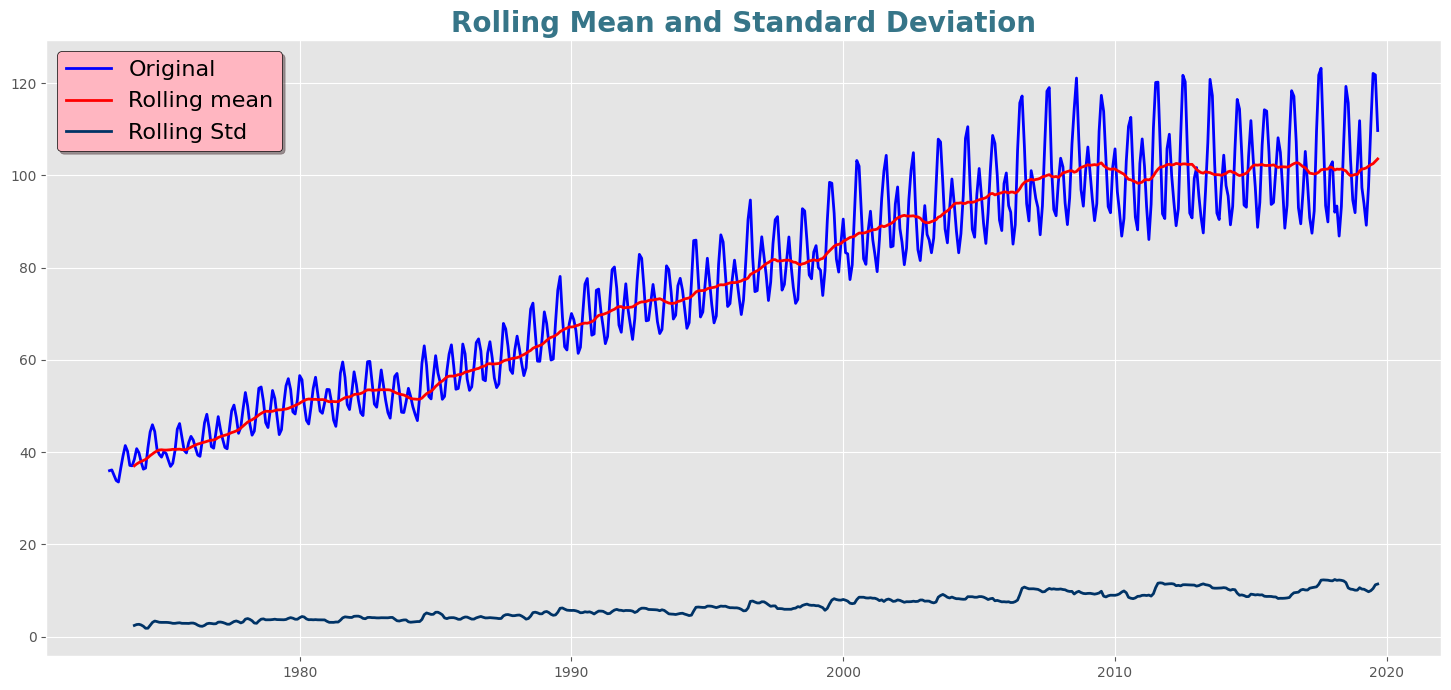

Augmented Dickey-Fuller test
Test Statistic: -1.7405933729832284
p-value: 0.41032816044687603
Critical Values: {'1%': -3.442405720052601, '5%': -2.866857804790472, '10%': -2.5696022094099824}
Fail to reject the null hypothesis; the time series is non-stationary.


In [43]:
# stationarity of original  time series data 
test_stationarity(df_ts['electricity_consumption'])

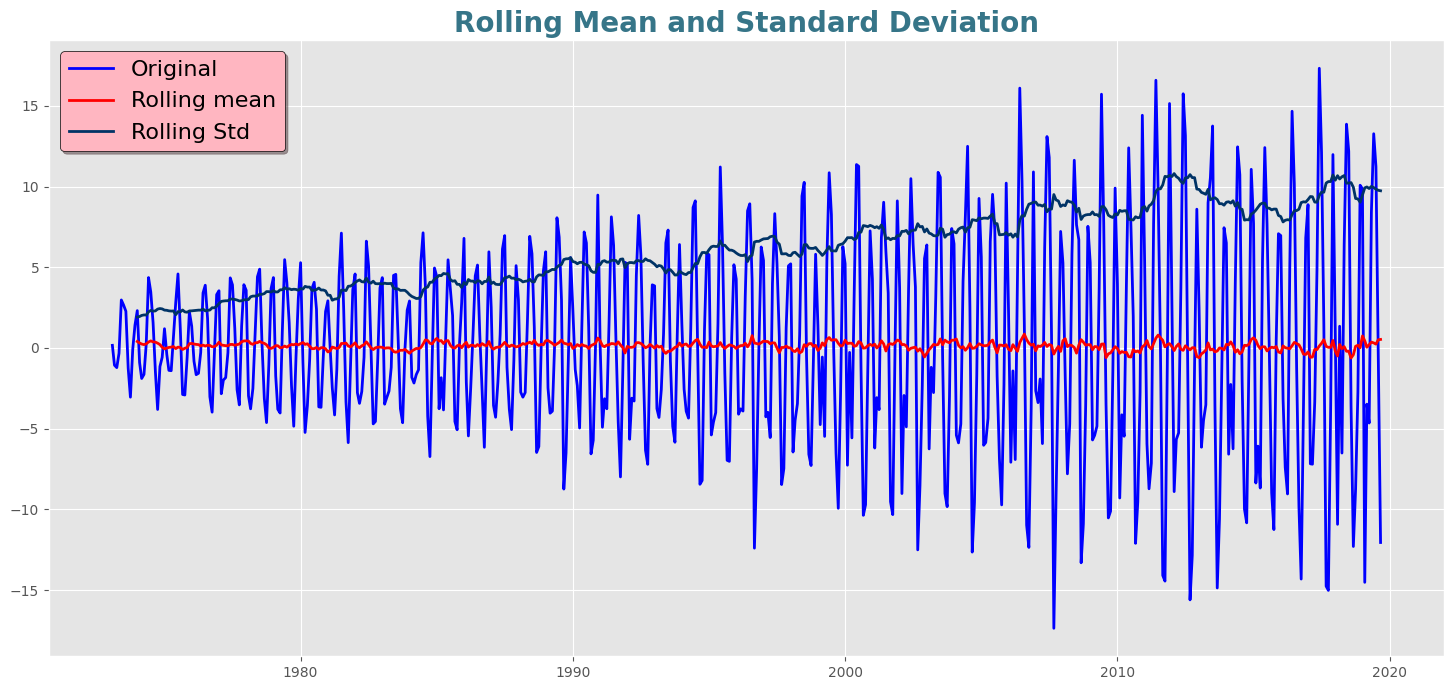

Augmented Dickey-Fuller test
Test Statistic: -7.941665363981172
p-value: 3.3013438021516752e-12
Critical Values: {'1%': -3.442405720052601, '5%': -2.866857804790472, '10%': -2.5696022094099824}
Reject the null hypothesis; the time series is stationary.


In [44]:
# 1st order differencing 
test_stationarity(df_ts['differencing_1'].dropna())

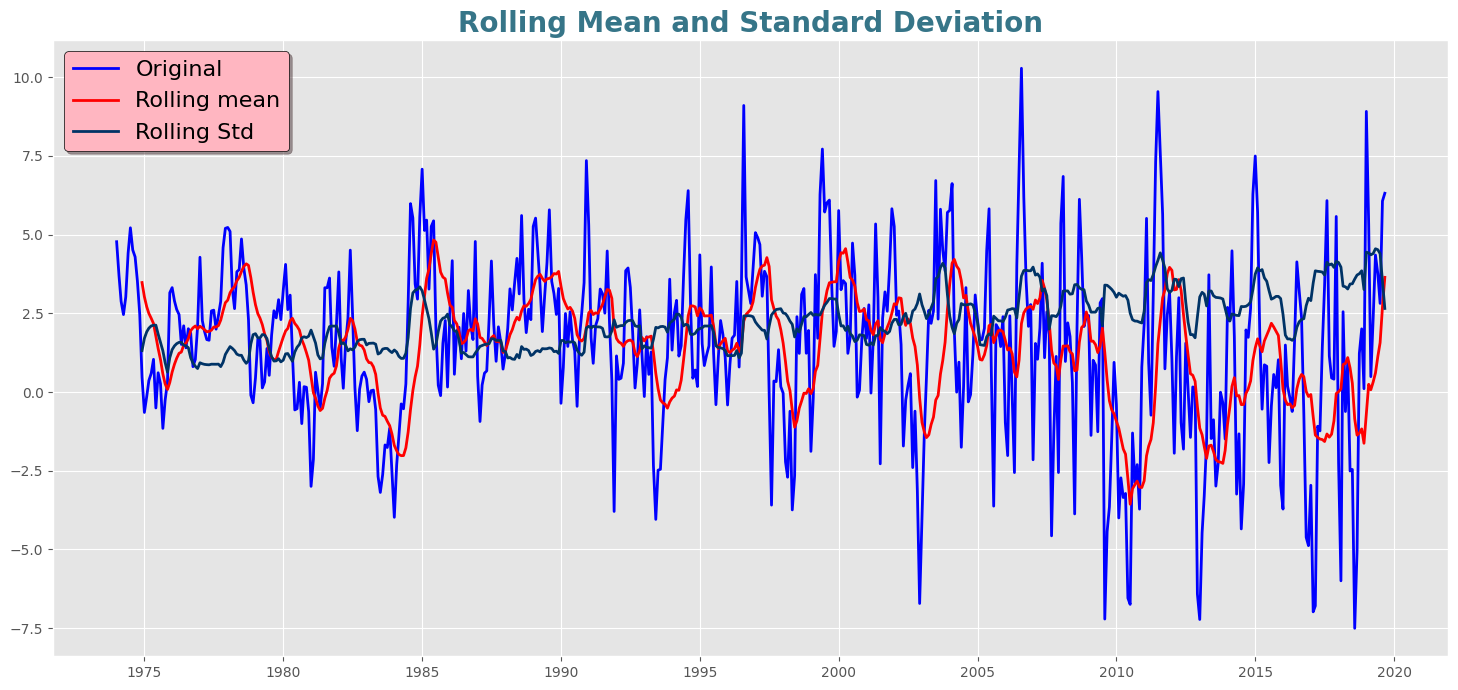

Augmented Dickey-Fuller test
Test Statistic: -6.283726159436479
p-value: 3.7419901755219934e-08
Critical Values: {'1%': -3.442609129942274, '5%': -2.866947348175723, '10%': -2.569649926626197}
Reject the null hypothesis; the time series is stationary.


In [45]:
# seasonal differencing 
test_stationarity(df_ts['seasonal_differencing_1'].dropna())

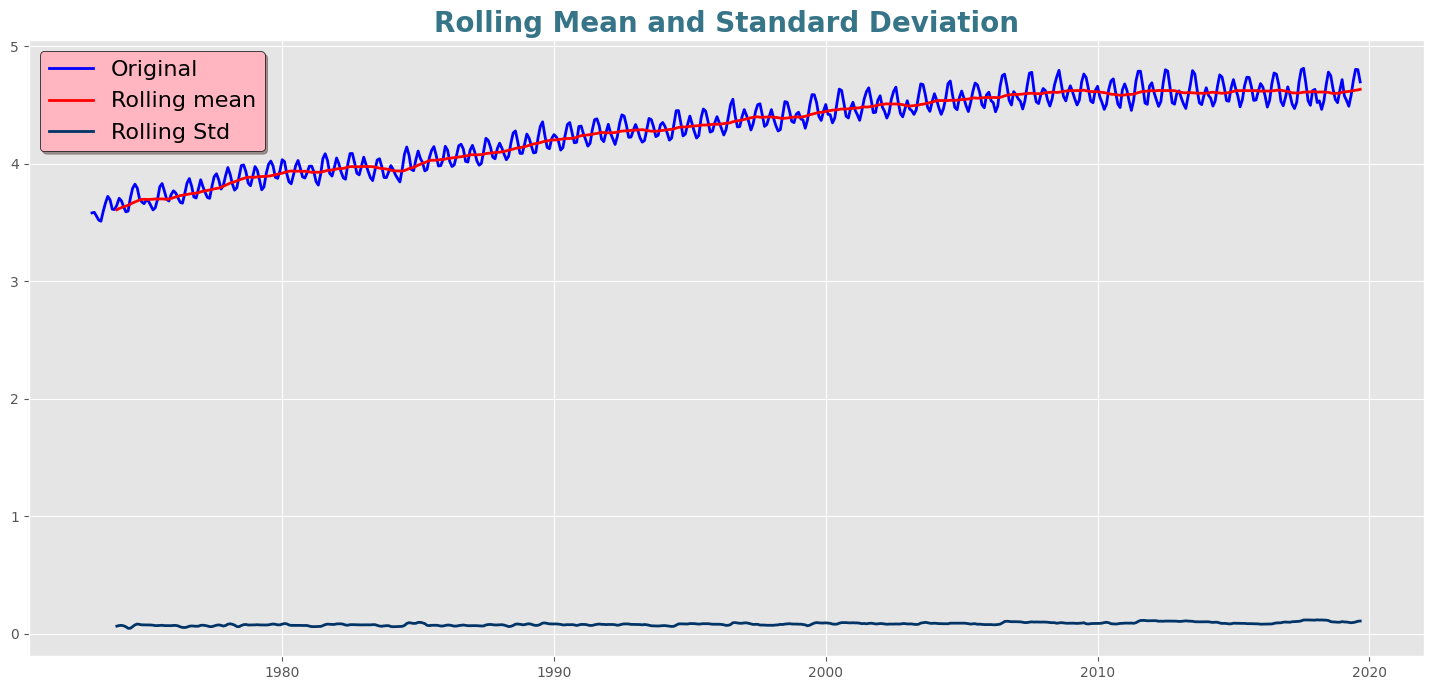

Augmented Dickey-Fuller test
Test Statistic: -3.001866678891593
p-value: 0.03472044330065344
Critical Values: {'1%': -3.442405720052601, '5%': -2.866857804790472, '10%': -2.5696022094099824}
Reject the null hypothesis; the time series is stationary.


In [46]:
# log data
test_stationarity(df_ts['log_electricity_consumption'])

#### **Auto Correlation Function(ACF) and Partial Auto Correlation Function(PACF) plots**

ACF and PACF are essential tools for understanding the temporal dependencies within a time series, aiding in the selection of appropriate models for time series forecasting, and providing insights into the underlying patterns and structures in the data.

In [47]:
# stationary time series data 
stationary_ts = df_ts['differencing_1'].dropna()

**Partial Auto Correlation Function(PACF)**

- Measures correlation while controlling for intervening lags.
- PACF helps determine the value of `p` (order of the autoregressive component).
- Significant spikes at specific lags in the PACF plot suggest the potential presence of an autoregressive effect. The lag where the PACF sharply drops off indicates the order of the autoregressive component.

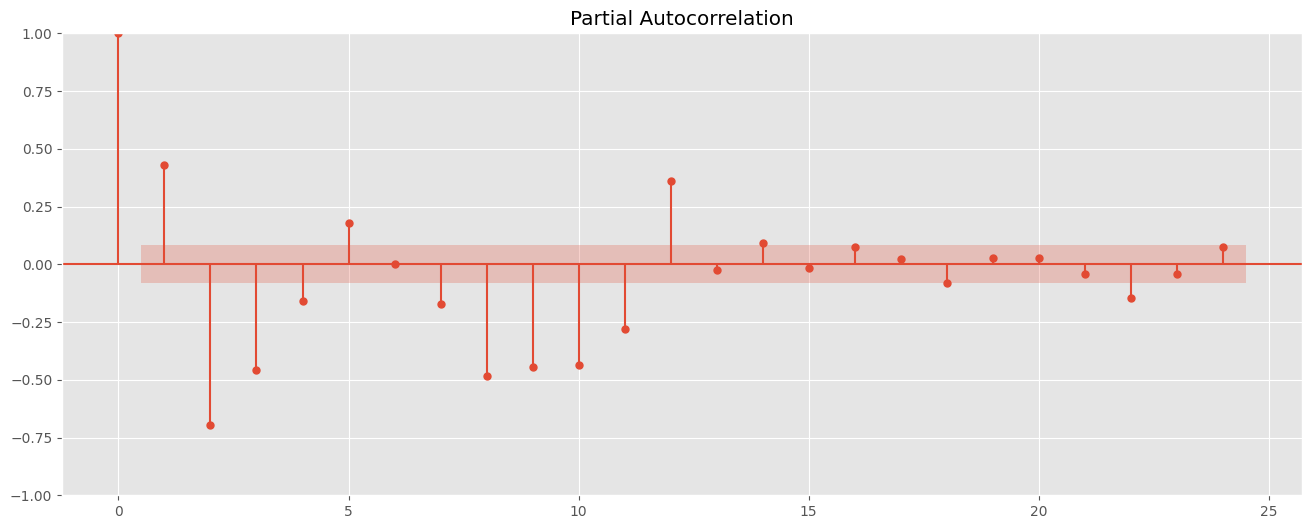

In [48]:
plot_pacf(stationary_ts, lags=24);

 **Auto Correlation Function(ACF)**

- Measures the correlation between a time series and its lagged values.
- Helps identify autocorrelation patterns and seasonality in time series data.
- ACF helps determine the value of `q `(order of the moving average component).
- Significant spikes at specific lags in the ACF plot suggest the potential presence of a moving average effect. The lag where the ACF sharply drops off indicates the order of the moving average.

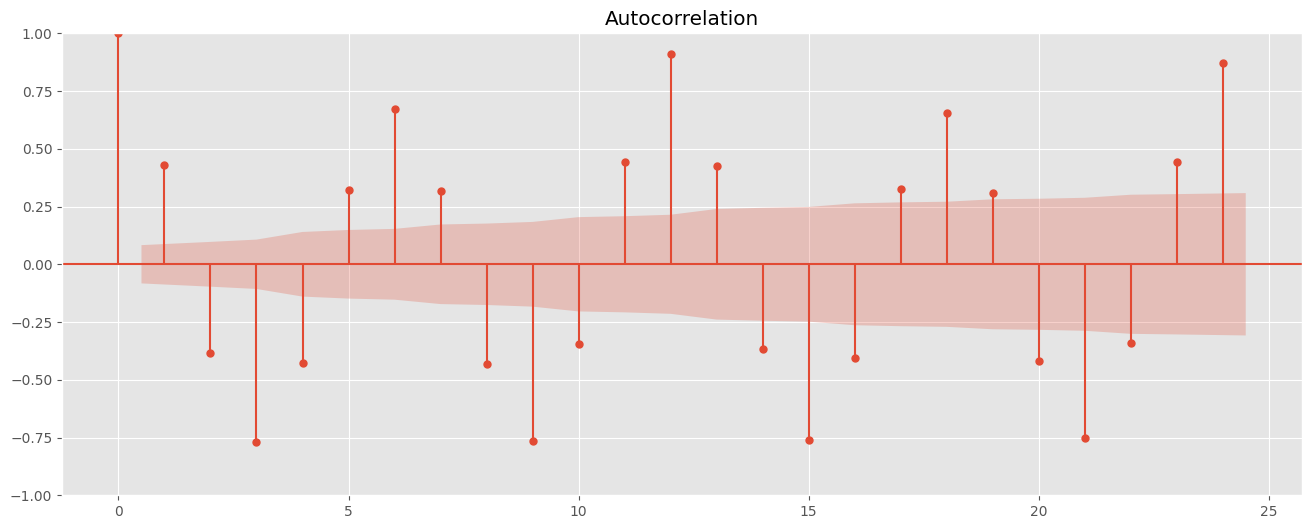

In [49]:
plot_acf(stationary_ts, lags=24);

#### **Train-Test split**

In [50]:
# select 24 months for test
Ntest = 24 
train_size = len(df_ts) - Ntest
train, test = df_ts[:train_size], df_ts[train_size:]

In [51]:
# train and test data 
train1 = train['electricity_consumption']
test1 = test['electricity_consumption']

**We define a function to validate our model performance through visualisation and calcualting error metrics**

In [52]:
def plot_fit_forecast_error(model_result, train_data, test_data):
    """
    Plot actual, fitted, and forecasted values, along with error metrics.

    Parameters:
    - model_result: Result object from the ARIMA model fit
    - train_data: Training data for the time series
    - test_data: Test data for the time series
    """

    # Plotting
    plt.figure(figsize=(18, 10))

    # Plot actual values
    plt.plot(train_data.index, train_data, label='Training Data', color='blue', alpha=0.3)
    plt.plot(test_data.index, test_data, label='Actual Test Data', color='blue', linestyle='dashed', alpha=0.5)

    # Plot fitted values
    predicted_train = model_result.fittedvalues
    plt.plot(train_data.index, predicted_train, label='Fitted Values', color='orange', alpha=0.8)

    # Forecast for the test set
    N_test = len(test_data)
    pred_result = model_result.get_forecast(N_test)
    forecast = pred_result.predicted_mean
    conf_int = pred_result.conf_int()
    lower, upper = conf_int.iloc[:, 0], conf_int.iloc[:, 1]

    # Plot forecasted values
    plt.plot(test_data.index, forecast, label='Forecast', linestyle='dashed', color='green', linewidth=2)
    plt.fill_between(test_data.index, lower, upper, color='green', alpha=0.2)

    # Set plot attributes
    plt.title('ARIMA Model: Actual vs. Predicted', weight='bold', fontsize=18, color='#367588')
    plt.xlabel('Month-Year', weight='bold')
    plt.ylabel('Electricity Consumption', weight='bold')

    # Add legend
    plt.legend(loc='best', fontsize=14, shadow=True, facecolor='lightpink', edgecolor='k')

    # Display the plot
    plt.show()

    # Display error metrics
    print("Error Metrics:")
    print(error_metrics(test_data.values, forecast.values))

In [53]:
def plot_actual_vs_forecast(actual, forecast):
    """
    Plot actual vs. forecasted values.

    Parameters:
    - actual: Actual time series data
    - forecast: Forecasted time series data
    """
    title = 'ARIMA Model Validation: Actual vs. Forecast'
    xlabel = 'Month-Year'
    ylabel = 'Electricity Consumption'

    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot the actual data
    ax.plot(actual.index, actual, label='Actual', color='blue')

    # Plot the forecasted values
    ax.plot(actual.index, forecast, label='Forecast', linestyle='dashed', color='green')

    # Set plot attributes
    ax.set_title(title, weight='bold', fontsize=16, color='#367588')
    ax.set_xlabel(xlabel, weight='bold')
    ax.set_ylabel(ylabel, weight='bold')

    # Add legend
    ax.legend(loc='best', fontsize=12, shadow=True, facecolor='lightpink', edgecolor='k')

    # Display the plot
    plt.show()

**NAIVE FORECAST**

In [54]:
def naive_forecast(train_data, test_data):
    # Use the last observed value in the training data as the forecast
    forecast = train_data.iloc[-1]
    
    # Repeat the forecast for the length of the test data
    naive_forecast = pd.Series(index=test_data.index, data=[forecast] * len(test_data))
    
    return naive_forecast

# Assuming train1 and test1 are your training and testing datasets
naive_predictions = naive_forecast(train1, test1)
print('Error metrics for Naive Forecast:')
print(error_metrics(test1.values, naive_predictions.values))

Error metrics for Naive Forecast:
{'RMSE': 12.504751903243294, 'RMSPE': 13.179673561909066, 'MAPE': 11.350215780522166}


 **Train ARIMA Model for various parameters (p,d,q) and Plot the forecast results** 

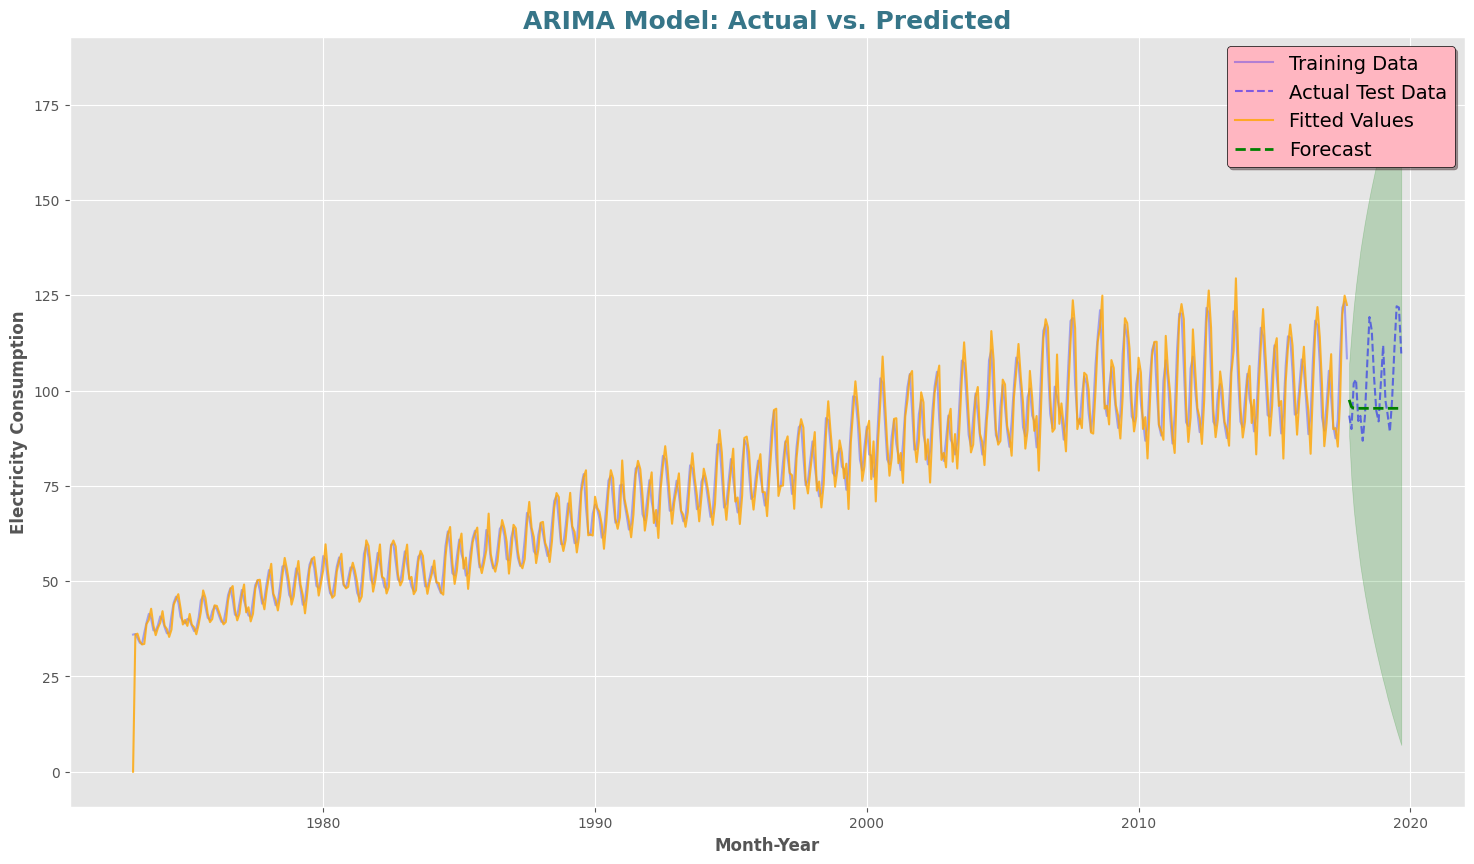

Error Metrics:
{'RMSE': 12.380038253137025, 'RMSPE': 10.850098973796431, 'MAPE': 8.676065016901847}


In [55]:
# Instantiate an ARIMA (AutoRegressive Integrated Moving Average) model with specified order parameters
# - `train1`: Training data used to fit the model.
# - `order=(1, 1, 1)`: Specifies the order of the ARIMA model with (p, d, q) parameters.
#   - `p` (autoregressive order) = 1
#   - `d` (differencing order) = 1
#   - `q` (moving average order) = 1
arima =  ARIMA(train1, order=(1,1,1))
arima_result = arima.fit()

plot_fit_forecast_error(arima_result, train1, test1)

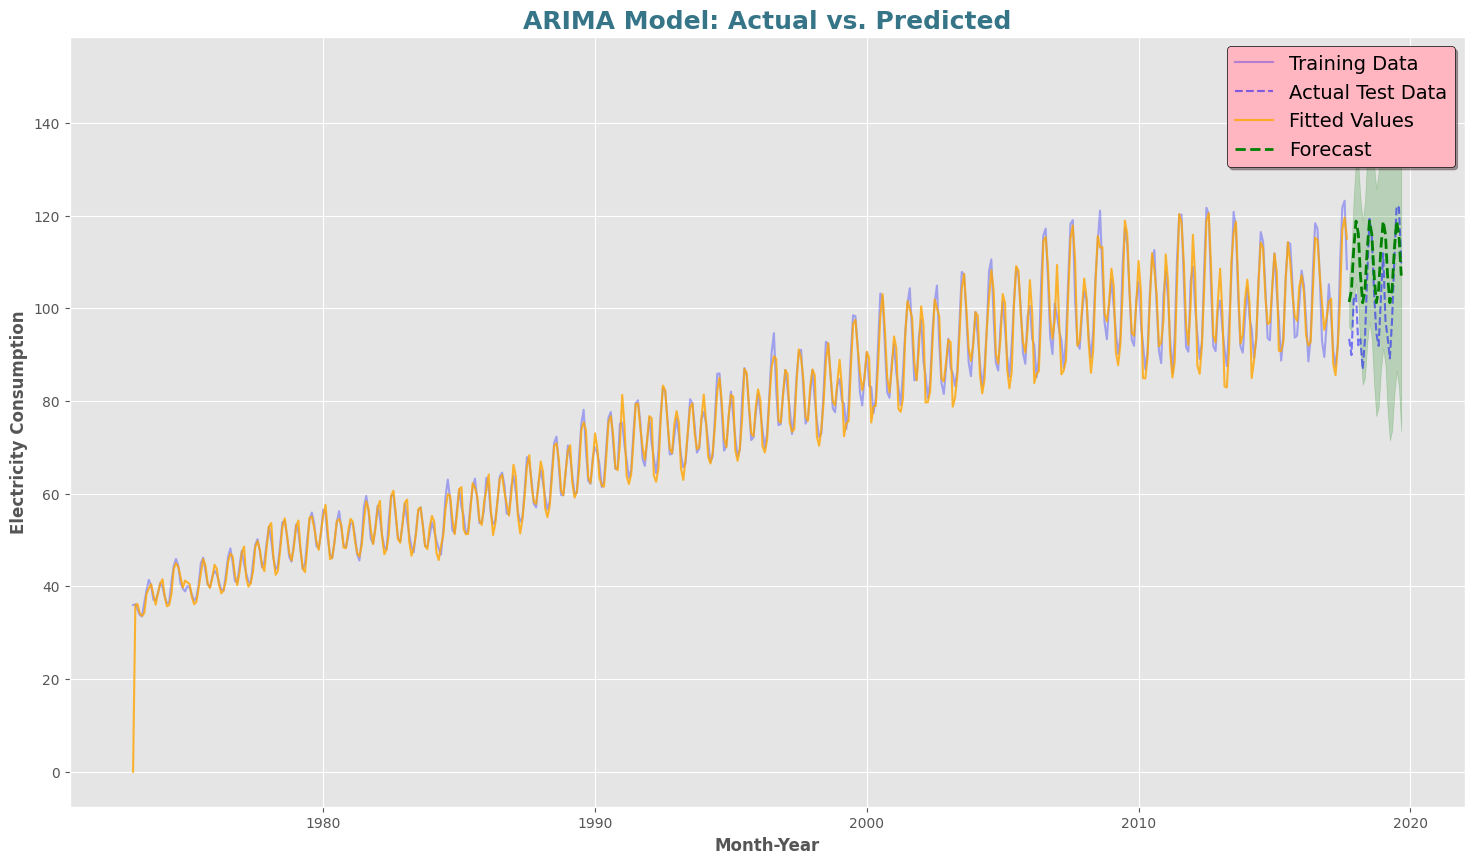

Error Metrics:
{'RMSE': 10.98828839616136, 'RMSPE': 11.60411733699709, 'MAPE': 9.639686062123099}


In [56]:
# Instantiate an ARIMA (AutoRegressive Integrated Moving Average) model with specified order parameters
# - `train1`: Training data used to fit the model.
# - `order=(3, 1, 2)`: Specifies the order of the ARIMA model with (p, d, q) parameters.
arima =  ARIMA(train1, order=(3,1,2))
arima_result = arima.fit()
plot_fit_forecast_error(arima_result, train1, test1)

**Enlarged Actual vs Predicted**

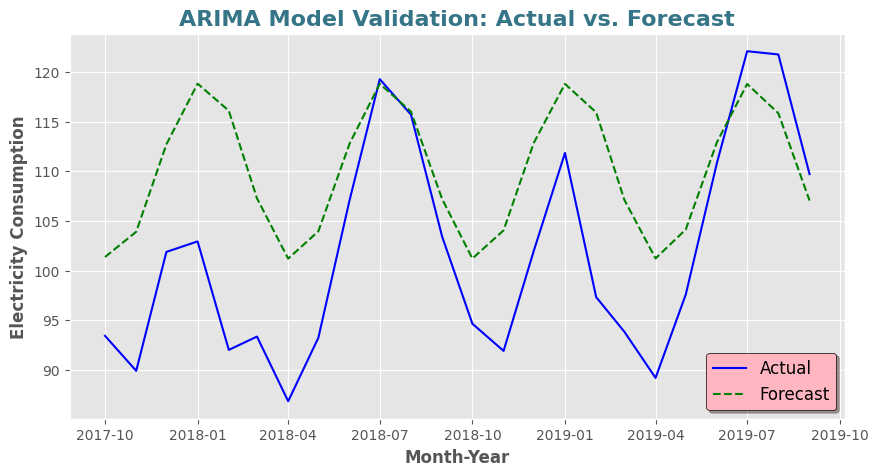

In [57]:
arima =  ARIMA(train1, order=(3,1,2))
arima_result = arima.fit()
N_test = len(test1)
pred_result = arima_result.get_forecast(steps=N_test)
forecast = pred_result.predicted_mean
plot_actual_vs_forecast(test1, forecast)

#### **Seasonal ARIMA**

Seasonal AutoRegressive Integrated Moving Average, is an extension of the ARIMA model that includes seasonality components. It is a powerful time series forecasting technique designed to capture and model seasonal patterns in data.

- SARIMA is effective for time series data that exhibit clear seasonal patterns or trends.
- It is valuable in forecasting data with recurring patterns at fixed intervals, such as monthly or yearly seasonality.
- SARIMA provides a flexible framework to model complex seasonal dependencies, making it suitable for a wide range of applications, including demand forecasting and financial time series analysis.

**SARIMA Model with Cross Validation** 

In [58]:
# Define an SARIMA (AutoRegressive Integrated Moving Average) model 
model = pm.ARIMA(
    order=(1, 1, 1),  # ARIMA order parameters
    seasonal_order=(1, 1, 1, 12),  # Seasonal order parameters (monthly with seasonality of 12)
    suppress_warnings=True,  
    force_stationarity=False  
)

# Create a RollingForecastCV object for time series cross-validation
cv = model_selection.RollingForecastCV(
    h=24,  # Forecast horizon (number of steps ahead)
    step=12,  # Number of steps between each training set
    initial=df_ts.shape[0] - (12 * 5)  # Index to start the initial training set
)

# Perform cross-validation using TimeSeriesSplit with mean squared error as the scoring metric
cv_score = model_selection.cross_val_score(
    estimator=model, 
    y=df_ts['electricity_consumption'],  # Target variable
    scoring='mean_squared_error',  # Scoring metric
    cv=cv,  
    verbose=2,  # Display progress information
    error_score=1000000000000  # Value to assign if an error occurs during cross-validation
)


[CV] fold=0 ..........................................................


[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................


In [59]:
# calcualte RMSE 
error = np.sqrt(np.average(cv_score)) 
print('Error (RMSE) : ', round(error, 4))

Error (RMSE) :  3.4543


#### **Parameter Tuning**

In [60]:
# # Define a parameter grid for hyperparameter tuning
param_grid = {
            'p' : np.arange(0,4),
            'd' : [1],
            'q' : np.arange(0,4),
            'P' : np.arange(0,4),
            'D' : [1],
            'Q' : np.arange(0,4)
            }
# Generate all possible combinations of hyperparameters
grid = ParameterGrid(param_grid)

In [62]:
# get the best parameters 
best_params = pd.read_csv('data/best_params_0123.csv')
best_params

,D,P,Q,d,p,q,rmse
238,1,3,2,1,3,2,3.144492


In [63]:
# transpose 
best_params = best_params.T
best_params


,238
D,1.000000
P,3.000000
Q,2.000000
d,1.000000
p,3.000000
q,2.000000
rmse,3.144492


In [64]:
# name the column
best_params.columns =['values']

In [65]:
# extract individual best parameters 
p = best_params.loc['p']['values']
d = best_params.loc['d']['values']
q = best_params.loc['q']['values']
P = best_params.loc['P']['values']
D = best_params.loc['D']['values']
Q = best_params.loc['Q']['values']

#### **Evaluation Metrics for best model:** 

In [66]:
# test size
Ntest = len(test)

# Instantiate a SARIMA model
sarima = pm.ARIMA(
    order=(p, d, q), 
    seasonal_order=(P, D, Q, 12), 
    suppress_warnings=True,  
    force_stationarity=False  
)
# Fit the SARIMA model to the time series data 
sarima_fit = sarima.fit(train1)
# forecast 
test_forecast = sarima.predict(n_periods=Ntest)

In [67]:
# recheck the parameters
sarima.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (3.0, 1.0, 2.0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': None,
 'seasonal_order': (3.0, 1.0, 2.0, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [68]:
# calcualate error metric 
error_metric_dict = error_metrics(test_values.ravel(), test_forecast.values)

In [69]:
# Convert the dictionary to a DataFrame
error_metrics_sarima = pd.DataFrame(error_metric_dict.items(), columns=['Metric', 'Value'])


In [70]:
# display error metric 
error_metrics_sarima

,Metric,Value
0,RMSE,3.076999
1,RMSPE,3.104236
2,MAPE,2.420767


#### **Forcasting Electricity demands for next 24 months**

In [71]:
# Set the number of periods for forecasting
forecast_periods = 24

# Instantiate a SARIMA model
sarima = pm.ARIMA(
    order=(p, d, q), 
    seasonal_order=(P, D, Q, 12), 
    suppress_warnings=True,  
    force_stationarity=False  
)

# Fit the SARIMA model to the time series data 
sarima_fit = sarima.fit(df_ts['electricity_consumption'])

In [72]:
 # Generate point forecasts and prediction intervals
forecast , conf_int = sarima_fit.predict(n_periods=forecast_periods, return_conf_int=True)

In [73]:
# create dataframe of forecast values 
forecast = pd.DataFrame(forecast)
forecast.head()

,0
2019-10-01,97.086720
2019-11-01,94.458009
2019-12-01,103.201972
2020-01-01,110.453740
2020-02-01,101.117407


In [74]:
# rename the column of the forecast DataFrame to 'electricity_demand_forecast'
forecast.columns = ['electricity_demand_forecast']

In [75]:
 # confidence interval for forcasting 
forecast['lower_lim'] = pd.Series(conf_int[:, 0], index=forecast.index)
forecast['upper_lim'] = pd.Series(conf_int[:, 1], index=forecast.index)

In [76]:
# forecasted values with confidence interval 
forecast

,electricity_demand_forecast,lower_lim,upper_lim
2019-10-01,97.086720,93.629171,100.544270
2019-11-01,94.458009,90.162200,98.753818
2019-12-01,103.201972,98.678198,107.725746
2020-01-01,110.453740,105.791305,115.116176
2020-02-01,101.117407,96.356406,105.878409
2020-03-01,96.227141,91.397500,101.056783
2020-04-01,90.121710,85.238657,95.004763
2020-05-01,96.396868,91.468255,101.325480
2020-06-01,110.441257,105.471871,115.410642
2020-07-01,121.337721,116.330545,126.344897


In [ ]:
# Create a figure
fig = go.Figure()

# Plot the actual time series data
fig.add_trace(go.Scatter(x=df_ts.index, y=df_ts['electricity_consumption'], mode='lines', name='Actual', line=dict(color='blue')))

# Plot the forecasted values
fig.add_trace(go.Scatter(x=forecast.index, y=forecast['electricity_demand_forecast'], mode='lines', name='Forecast', line=dict(color='green', dash='dash', width=2)))

# Plot the confidence interval
fig.add_trace(go.Scatter(x=forecast.index, y=forecast['lower_lim'], fill='tonexty', mode='lines', line=dict(color='orange', width=0), fillcolor='rgba(255, 165, 0, 0.2)', name='Confidence Interval'))
fig.add_trace(go.Scatter(x=forecast.index, y=forecast['upper_lim'], fill='tonexty', mode='lines', line=dict(color='orange', width=0), fillcolor='rgba(255, 165, 0, 0.2)', showlegend=False))

# Customize the layout
fig.update_layout(
    title='Electricity Demand Forecast with Confidence Interval',
    xaxis=dict(title='Date', showgrid=True),
    yaxis=dict(title='Electricity Demand', showgrid=True),
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    margin=dict(l=0, r=0, t=40, b=0),
)

#### **Plot the Electricity Demand Forcast**

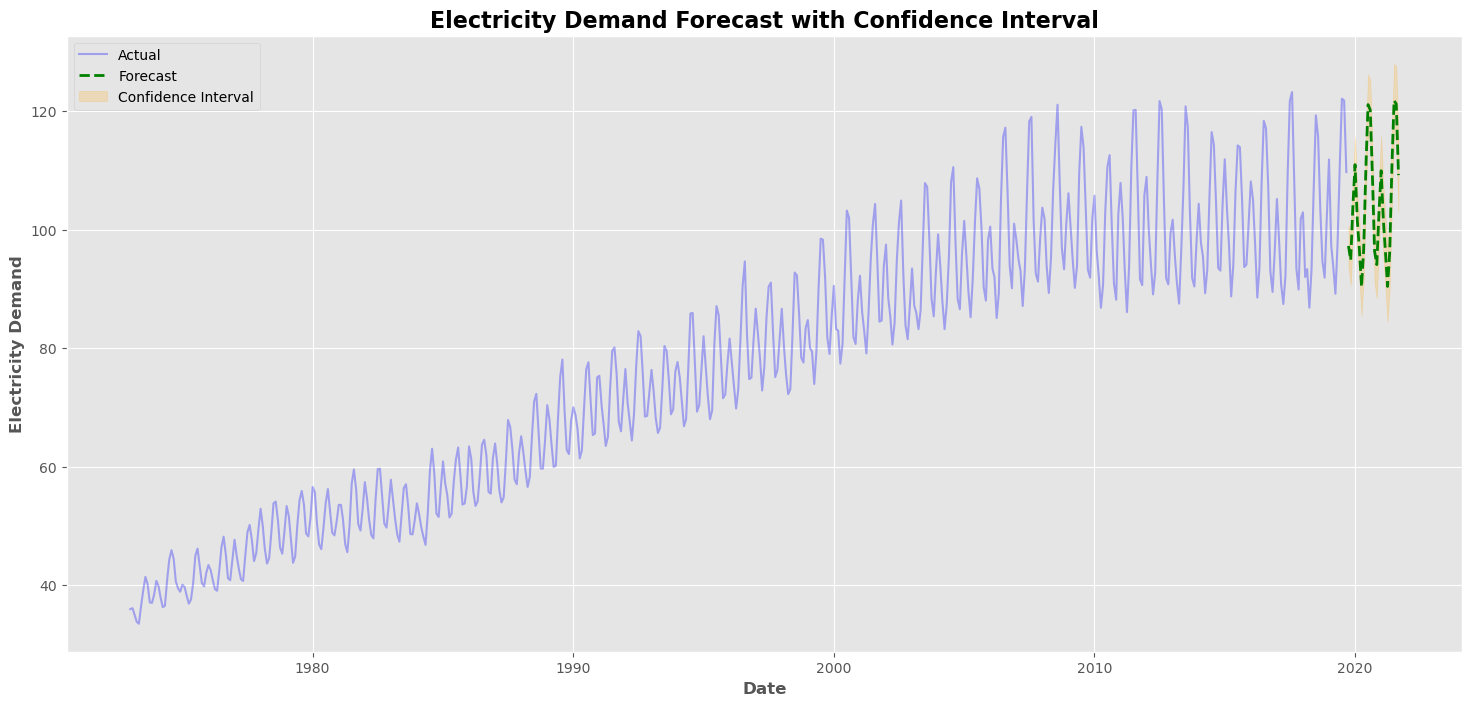

In [ ]:
# Plot the time series data
plt.figure(figsize=(18, 8))
plt.plot(df_ts.index, df_ts['electricity_consumption'], label='Actual', color='blue', alpha= 0.3)

# Plot the forecasted values
plt.plot(forecast.index, forecast['electricity_demand_forecast'], label='Forecast', color='green', linestyle='dashed', linewidth=2)

# Plot the confidence interval
plt.fill_between(forecast.index, 
                 forecast['lower_lim'], 
                 forecast['upper_lim'], 
                 color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('Electricity Demand Forecast with Confidence Interval', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=12, weight='bold')
plt.ylabel('Electricity Demand', fontsize=12, weight='bold')
plt.legend()
plt.show()

**Plot only forcasted data** 

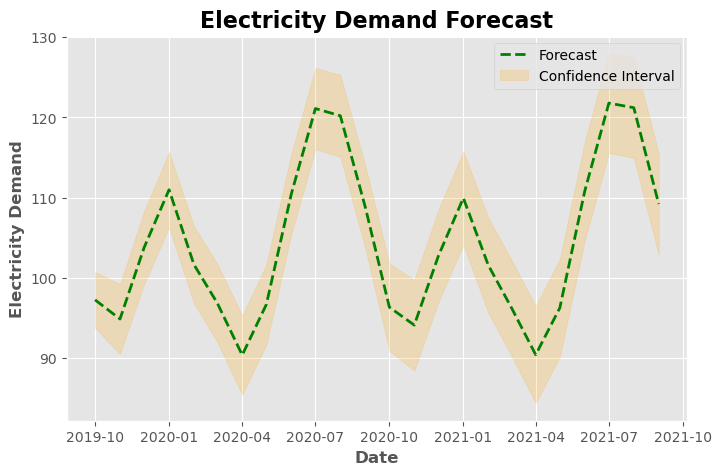

In [ ]:
# Plot the time series data
plt.figure(figsize=(8, 5))
# Plot the forecasted values
plt.plot(forecast.index, forecast['electricity_demand_forecast'], label='Forecast', color='green', linestyle='dashed', linewidth=2)

# Plot the confidence interval
plt.fill_between(forecast.index, 
                 forecast['lower_lim'], 
                 forecast['upper_lim'], 
                 color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('Electricity Demand Forecast', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=12, weight='bold')
plt.ylabel('Electricity Demand', fontsize=12, weight='bold')
plt.legend()
plt.show()

**Save the model**

In [87]:
# save the model as pkl
pickle.dump(sarima, open('models/sarima_model.pkl', 'wb'))